# 1. Import Dependencies

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable 

from neuralprophet import NeuralProphet

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
import seaborn as sns

import pandas as pd
import datetime as dt
import requests

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr as PCC

print("All libraries loaded")

All libraries loaded


# 2. Download Data

In [2]:
def download_data(url, name='', usecols=None, sheet_name=1, header=2, plot=False): 
    global config
    
    r = requests.get(url)
    open('temp.xls', 'wb').write(r.content)
    df = pd.read_excel('temp.xls', sheet_name=sheet_name, header=header, usecols=usecols) 
    df = df[~df.isnull().any(axis=1)] # remove rows with any missing data
       
    num_data_points = len(df)
    
    df2 = df.iloc[[0, -1]]    
    date_range = "from " + str(df2.iloc[0,0]) + " to " + str(df2.iloc[1,0])
    print(date_range, str(num_data_points) + ' Data Points')
    
    data_dict = {}
    data_dict['data'] = df.rename(columns={df.keys()[0]: 'date', 
                            df.keys()[1]: name})
    data_dict['num elements'] = num_data_points
    data_dict['date range'] = date_range
    data_dict['name'] = df.keys()[1]
    
    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_dict['data']['date'], data_dict['data'][name], color=config["plots"]["color_actual"])
        plt.title(data_dict['name'] + ", " + data_dict['date range'] + ", " + str(data_dict['num elements']) + " Data Points")

        # Format the x axis
        locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
        fmt = mdate.DateFormatter('%Y-%m')
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        # Specify formatter
        X.set_major_formatter(fmt)
        plt.xticks(rotation='vertical')
        plt.xlim([data_dict['data'].iloc[0,0], data_dict['data'].iloc[-1,0]])

        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.show()
         
    return data_dict

In [3]:
plot = False

## 2a. Seattle Gas Prices (targets)

In [4]:
seattle_gas_prices = download_data('https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMRU_PTE_Y48SE_DPGw.xls', 
                                   name='gas price',
                                  plot=plot)

print(seattle_gas_prices['data'].head())

from 2003-05-26 00:00:00 to 2022-07-04 00:00:00 998 Data Points
        date  gas price
0 2003-05-26      1.534
1 2003-06-02      1.524
2 2003-06-09      1.522
3 2003-06-16      1.578
4 2003-06-23      1.580


## 2b. U.S. Crude Oil Stock Change (feature 1)

In [5]:
us_oil_stock = download_data('https://www.eia.gov/dnav/pet/hist_xls/MCRSCUS1m.xls',
                             name='oil stock exchange',
                             plot=plot)

print(us_oil_stock['data'].head())

from 1981-01-15 00:00:00 to 2022-04-15 00:00:00 496 Data Points
        date  oil stock exchange
0 1981-01-15               -1535
1 1981-02-15                7773
2 1981-03-15               19596
3 1981-04-15               17853
4 1981-05-15               12109


## 2c. U.S. Natural Gas Rotary Rigs in Operation (feature 2)

In [6]:
us_drilling_activity = download_data('https://www.eia.gov/dnav/pet/hist_xls/E_ERTRRG_XR0_NUS_Cm.xls',
                             name='drilling activity',
                             plot=plot)

print(us_drilling_activity['data'].head())

from 1987-08-15 00:00:00 to 2022-03-15 00:00:00 416 Data Points
          date  drilling activity
175 1987-08-15              352.0
176 1987-09-15              364.0
177 1987-10-15              377.0
178 1987-11-15              386.0
179 1987-12-15              403.0


## 2d. U.S. Natural Gas Production (feature 3)

In [7]:
us_gas_production = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9050US2m.xls',
                             name='gas production',
                             plot=plot)

print(us_gas_production['data'].head())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
        date  gas production
0 1973-01-15         1948000
1 1973-02-15         1962000
2 1973-03-15         1907000
3 1973-04-15         1814000
4 1973-05-15         1898000


## 2e. U.S. Natural Gas Consumption (feature 4)

In [8]:
us_gas_consumption = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9140US2m.xls',
                             name='gas consumption',
                             plot=plot)

print(us_gas_consumption['data'].head())

from 2001-01-15 00:00:00 to 2022-04-15 00:00:00 256 Data Points
        date  gas consumption
0 2001-01-15          2676998
1 2001-02-15          2309464
2 2001-03-15          2246633
3 2001-04-15          1807170
4 2001-05-15          1522382


## 2f. Underground Natural Gas Storage Capacity (feature 5)

In [9]:
us_gas_storage = download_data('https://www.eia.gov/dnav/ng/xls/NG_STOR_CAP_DCU_NUS_M.xls',
                             name='gas storage',
                               usecols='A:B',
                             plot=plot)

print(us_gas_storage['data'].head())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
        date  gas storage
0 1989-01-15      8119368
1 1989-02-15      8119368
2 1989-03-15      8119368
3 1989-04-15      8119368
4 1989-05-15      8119368


## 2g. U.S. Natural Gas Import Volumes (feature 6)

In [10]:
us_gas_import_volume = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import volume',
                               usecols='A:B',
                               sheet_name=1,
                             plot=plot)

print(us_gas_import_volume['data'].tail())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
          date  gas import volume
587 2021-12-15             252626
588 2022-01-15             296179
589 2022-02-15             259389
590 2022-03-15             260642
591 2022-04-15             246576


## 2g. U.S. Natural Gas Import Prices (feature 7)

In [11]:
us_gas_import_price = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import price',
                               usecols='A:B',
                               sheet_name=2,
                             plot=plot)

print(us_gas_import_price['data'].tail())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
          date  gas import price
395 2021-12-15              4.74
396 2022-01-15              6.87
397 2022-02-15              5.62
398 2022-03-15              4.67
399 2022-04-15              5.46


## 2h. Henry Hub Natural Gas Spot Price (feature 8)

In [12]:
hh_natural_gas_price = download_data('https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls',
                             name='natural gas price',
                             plot=plot)

print(hh_natural_gas_price['data'].head())

from 1997-01-15 00:00:00 to 2022-06-15 00:00:00 306 Data Points
        date  natural gas price
0 1997-01-15               3.45
1 1997-02-15               2.15
2 1997-03-15               1.89
3 1997-04-15               2.03
4 1997-05-15               2.25


## 2i. Crude Oil Sport Price (feature 9)

In [13]:
us_crude_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='crude oil price',
                                   usecols='A:B',
                                   sheet_name=1, 
                                   plot=plot)

print(us_crude_oil_price['data'].head())

from 1986-01-15 00:00:00 to 2022-06-15 00:00:00 438 Data Points
        date  crude oil price
0 1986-01-15            22.93
1 1986-02-15            15.46
2 1986-03-15            12.61
3 1986-04-15            12.84
4 1986-05-15            15.38


## 2j. Conventional Gasoline Price (feature 10)

In [14]:
us_gas_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='conventional gas price',
                                   usecols='A:B',
                                   sheet_name=2, 
                                   plot=plot)

print(us_gas_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  conventional gas price
0 1986-06-15                   0.420
1 1986-07-15                   0.340
2 1986-08-15                   0.426
3 1986-09-15                   0.420
4 1986-10-15                   0.410


## 2k. RBOB Gasoline Price (feature 11)

In [15]:
us_rbob_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='rbob gas price',
                                   usecols='A:B',
                                   sheet_name=3, 
                                   plot=plot)

print(us_rbob_price['data'].head())

from 2003-06-15 00:00:00 to 2022-06-15 00:00:00 229 Data Points
        date  rbob gas price
0 2003-06-15           1.072
1 2003-07-15           0.965
2 2003-08-15           1.315
3 2003-09-15           0.949
4 2003-10-15           0.996


## 2l. Heating Oil Price (feature 12)

In [16]:
us_heating_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='heating oil price',
                                   usecols='A:B',
                                   sheet_name=4, 
                                   plot=plot)

print(us_heating_oil_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  heating oil price
0 1986-06-15              0.380
1 1986-07-15              0.334
2 1986-08-15              0.408
3 1986-09-15              0.402
4 1986-10-15              0.394


## 2m. Diesel Price (feature 13)

In [17]:
us_diesel_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='diesel price',
                                   usecols='A:B',
                                   sheet_name=5, 
                                   plot=plot)

print(us_diesel_price['data'].head())

from 2006-06-15 00:00:00 to 2022-06-15 00:00:00 193 Data Points
          date  diesel price
122 2006-06-15         2.091
123 2006-07-15         2.217
124 2006-08-15         2.247
125 2006-09-15         1.810
126 2006-10-15         1.794


## 2n. Kerosene Price (feature 14)

In [18]:
us_kerosene_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='kerosene price',
                                   usecols='A:B',
                                   sheet_name=6, 
                                   plot=plot)

print(us_kerosene_price['data'].tail())

from 1990-04-15 00:00:00 to 2022-06-15 00:00:00 387 Data Points
          date  kerosene price
382 2022-02-15           2.682
383 2022-03-15           3.495
384 2022-04-15           3.914
385 2022-05-15           3.902
386 2022-06-15           4.120


## 2o. Propane Price (feature 15)

In [19]:
us_propane_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='propane price',
                                   usecols='A:B',
                                   sheet_name=7, 
                                   plot=plot)

print(us_propane_price['data'].tail())

from 1992-06-15 00:00:00 to 2022-06-15 00:00:00 361 Data Points
          date  propane price
356 2022-02-15          1.283
357 2022-03-15          1.448
358 2022-04-15          1.302
359 2022-05-15          1.223
360 2022-06-15          1.219


# 3. Combine Feature and Target Data

In [20]:
# features
feature_list = [
    hh_natural_gas_price['data'],
    us_crude_oil_price['data'],
    us_gas_price['data'],
    us_rbob_price['data'],
    us_heating_oil_price['data'],
    us_diesel_price['data'],
    us_kerosene_price['data'],
    us_propane_price['data'],
    us_oil_stock['data'],
    us_drilling_activity['data'],
    us_gas_production['data'],
    us_gas_consumption['data'],
    us_gas_storage['data'],
    us_gas_import_volume['data'],
    us_gas_import_price['data']
]

# targets
targets = seattle_gas_prices['data'].set_index('date')

In [21]:
# reindex and concatenate features
kw = dict(method="time")
for i in range(0, len(feature_list)):
    if i > 1:
        feature = feature_list[i].set_index('date')
        feature = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)
        features = features.join(feature)
    else:
        feature = pd.DataFrame(feature_list[i]).set_index('date')
        features = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)  

# add week number (1-52) as a feature
features['week number'] = features.index.isocalendar().week
features['week number'] = features['week number'].astype(float)
    
# combine features and targets into one data frame
features_targets = features.join(targets)

# get rid of rows with any missing data
features_targets = features_targets[~features_targets.isnull().any(axis=1)]

# convert index datetimes to dates (exclude hour, minute, second)
features_targets.index = features_targets.index.date
features_targets

,crude oil price,conventional gas price,rbob gas price,heating oil price,diesel price,kerosene price,propane price,oil stock exchange,drilling activity,gas production,gas consumption,gas storage,gas import volume,gas import price,week number,gas price
2006-06-19,71.411333,2.087933,2.412600,1.926333,2.107800,2.090733,1.106067,-4598.933333,1376.400000,1.618895e+06,1.578593e+06,8.247523e+06,351139.000000,5.846000,25.0,3.067
2006-06-26,72.218667,2.128067,2.432900,1.928667,2.137200,2.107767,1.121933,-4744.066667,1377.100000,1.627353e+06,1.627092e+06,8.249157e+06,356466.000000,5.874000,26.0,3.027
2006-07-03,73.026000,2.168200,2.453200,1.931000,2.166600,2.124800,1.137800,-4889.200000,1377.800000,1.635812e+06,1.675591e+06,8.250790e+06,361793.000000,5.902000,27.0,3.004
2006-07-10,73.833333,2.208333,2.473500,1.933333,2.196000,2.141833,1.153667,-5034.333333,1378.500000,1.644271e+06,1.724091e+06,8.252423e+06,367120.000000,5.930000,28.0,3.032
2006-07-17,74.321613,2.224161,2.468774,1.938161,2.218935,2.152645,1.163258,-4727.161290,1381.451613,1.650682e+06,1.758278e+06,8.253590e+06,370540.935484,6.000968,29.0,3.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-06,113.304194,4.008258,4.201484,4.318871,4.444452,4.056710,1.220161,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,23.0,5.416
2022-06-13,114.498710,4.065613,4.254774,4.262194,4.380323,4.105935,1.219258,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,24.0,5.549
2022-06-20,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,25.0,5.518
2022-06-27,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,26.0,5.461


# 4. Data Preprocessing

In [22]:
data = features_targets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # training device
timesteps = 10 # lookback window
n_timeseries = data.shape[1] - 1 # input size
batch_size = 16
max_epochs = 250
target_name = 'gas price' # target variable name

## 4a. Incorporate Rolling Lookback Window

In [23]:
# Preallocate feature and target arrays
X_ = np.zeros((len(data), timesteps, data.shape[1]-1))
y_ = np.zeros((len(data), timesteps, 1))

In [24]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X_[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [25]:
for j in range(timesteps):
    y_[:, j, 0] = data[target_name].shift(timesteps - j - 1).fillna(method="bfill")

In [26]:
prediction_horizon = 1
target_ = data[target_name].shift(-prediction_horizon).fillna(method="ffill").values

## 4b. Build Training, Validation, and Testing Datasets

In [27]:
# Dataset indices
up_to_train_idx = int(data.shape[0]*0.70)
up_to_val_idx = int(data.shape[0]*0.85)

# Number of data points in each dataset
train_length = up_to_train_idx
val_length = up_to_val_idx - up_to_train_idx
test_length = data.shape[0] - train_length - val_length

print(train_length, val_length, test_length)

586 126 126


In [28]:
X = X_[timesteps:]
y = y_[timesteps:]
target = target_[timesteps:]

In [29]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

## 4c. Normalize Data

In [30]:
class Normalizer():
    def __init__(self):
        self.max = None
        self.min = None
        self.range = None

    def fit_transform(self, x):
        self.max = x.max(axis=0)
        self.min = x.min(axis=0)
        self.range = self.max - self.min
        normalized_x = (x - self.min)/self.range
        return normalized_x
    
    def transform(self, x):
        return (x - self.min)/self.range

    def inverse_transform(self, x):
        return (x*self.range) + self.min

In [31]:
x_scaler = Normalizer()
y_his_scaler = Normalizer()
target_scaler = Normalizer()

In [32]:
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)

y_his_train = y_his_scaler.fit_transform(y_his_train)
y_his_val = y_his_scaler.transform(y_his_val)
y_his_test = y_his_scaler.transform(y_his_test)

target_train = target_scaler.fit_transform(target_train)
target_val = target_scaler.transform(target_val)
target_test = target_scaler.transform(target_test)

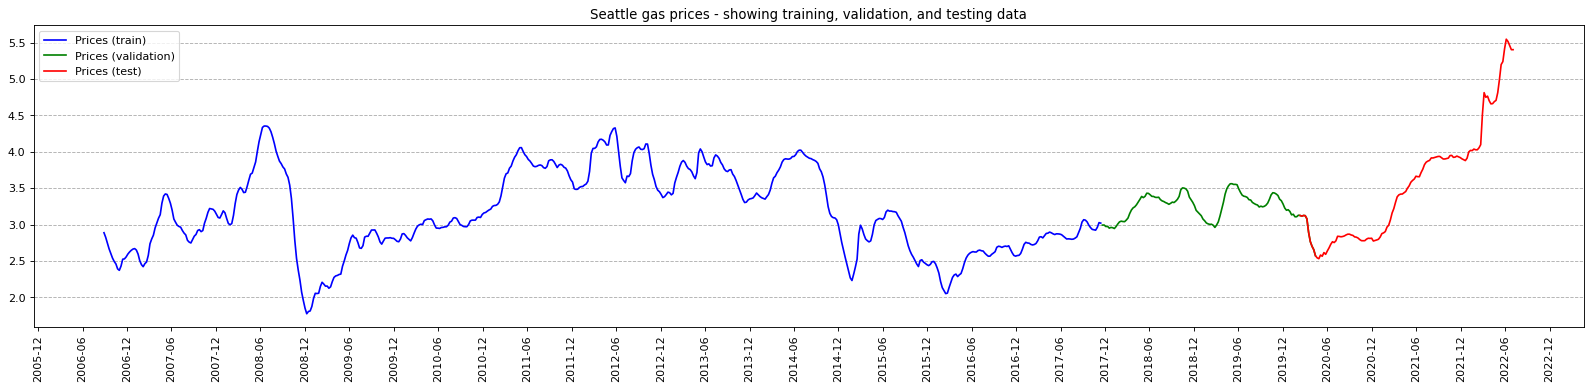

In [33]:
## Prepare data for plotting
data_date = features_targets.index.tolist()[timesteps:]
num_data_points = len(y)

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)
to_plot_data_y_test = np.zeros(num_data_points)

to_plot_data_y_train[:train_length] = target_scaler.inverse_transform(target_train)
to_plot_data_y_val[train_length:train_length+val_length] = target_scaler.inverse_transform(target_val)
to_plot_data_y_test[-val_length:] = target_scaler.inverse_transform(target_test)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

## Plotting
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color='blue')
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color='green')
plt.plot(data_date, to_plot_data_y_test, label="Prices (test)", color='red')

# Format the x axis
locator = mdate.MonthLocator(interval=6)
fmt = mdate.DateFormatter('%Y-%m')
X = plt.gca().xaxis
X.set_major_locator(locator) # error
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks(rotation='vertical')
# plt.xlim([data_date[0], data_date[-1]])

plt.title("Seattle gas prices - showing training, validation, and testing data")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

## 4d. Build Torch Data Loaders

In [34]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [35]:
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batch_size)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batch_size)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batch_size)

# 6. Modeling

In [36]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [37]:
def nn_train(model, model_name, epochs, data_train_loader, data_val_loader, opt, scheduler, target_scaler, plot=True):
    
    loss = nn.MSELoss()

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=50, verbose=True, path=f'{model_name}.pt') 

    for i in range(epochs):
        mse_train = 0

        for batch_x, batch_y_h, batch_y in data_train_loader :

            batch_x = batch_x.to(device)  
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            opt.zero_grad()
            
            if model_name == 'lstm':
                h, c = model.init_hidden_internal(batch_x.shape[0])
                y_pred, h, c = model(batch_x, batch_y_h, h, c)
            else:
                y_pred = model(batch_x, batch_y_h)

            y_pred = y_pred.squeeze(1)        
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()

        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y_h, batch_y in data_val_loader:

                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                batch_y_h = batch_y_h.to(device)
                
                if model_name == 'lstm':
                    h, c = model.init_hidden_internal(batch_x.shape[0])
                    output, h, c = model(batch_x, batch_y_h, h, c)
                else:
                    output = model(batch_x, batch_y_h)

                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
                
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        # Learning rate scheduler
        scheduler.step(mse_val/len(X_val_t))
        lr = opt.param_groups[0]['lr']

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(mse_val/len(X_val_t), model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, 
              "val: ", (mse_val/len(X_val_t))**0.5, 
              "LR: ", lr
             )
        if (plot == True) and (i % 10 == 0):
#             preds = preds*(target_train_max - target_train_min) + target_train_min
#             true = true*(target_train_max - target_train_min) + target_train_min
            preds = target_scaler.inverse_transform(preds)
            true = target_scaler.inverse_transform(true)
            mse = mean_squared_error(true, preds)
            mae = mean_absolute_error(true, preds)
            print("mse: ", mse, "mae: ", mae)
            plt.figure(figsize=(12, 6))
            plt.plot(preds, label='predicted')
            plt.plot(true, marker=".", markersize=10, color='black', linestyle = 'None', label='actual')
            plt.legend(loc="upper left")
            plt.title(f'Validation Results for Epoch {i}')
            plt.show()
    return

In [38]:
def nn_eval(model, model_name, data_test_loader, target_scaler):
    
    with torch.no_grad():
        mse_val = 0
        loss = nn.MSELoss()
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_test_loader:
            h, c = lstm.init_hidden_internal(batch_x.shape[0])
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            
            if model_name == 'lstm':
                h, c = model.init_hidden_internal(batch_x.shape[0])
                output, h, c = model(batch_x, batch_y_h, h, c)
            else:
                output = model(batch_x, batch_y_h)
                
            output = output.squeeze(1)
            
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(torch.squeeze(output), batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    # De-normalize
    preds = target_scaler.inverse_transform(preds)
    true = target_scaler.inverse_transform(true)
    
    # Collect results
    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)
    pcc, _ = PCC(true, preds)  
    err = true - preds
    
    # Time series plot
    plt.figure(figsize=(12, 6))
    plt.plot(preds, label='preds')
    plt.plot(true, marker=".", markersize=10, color='black', linestyle = 'None', label='actual')
    plt.legend(loc="upper left")
    plt.title(f'Test Results for {model_name.upper()} Model', fontsize=15)
    plt.xlabel('Samples', fontsize=12)
    plt.ylabel('Seattle Gas Price', fontsize=12)
    plt.show()
    
    # Scatter Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.regplot(ax=ax, x=true, y=preds)
    ax.set_xlabel('True Values', fontsize=12)
    ax.set_ylabel('Predictions', fontsize=12)
    ax.set_title(f'Test Prediction Correlation \n R2 = {r2:.3f} \n PCC = {pcc:.3f}', fontsize=15)
    ax.set_aspect('equal', 'box')
    
    # Error Histogram
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(ax=ax, data=err, kde=True)
    ax.set_xlabel('Prediction Errors (U.S. $)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Model Testing Prediction Errors \n MSE = {mse:.3f} \n MAE = {mae:.3f}', fontsize=15)
    
    return mse, mae, r2, pcc, preds, true

In [59]:
def prepare_forecast_x_data(x, window_size, input_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, 
                                             shape=(n_row, window_size, input_size),  
                                             strides=(x.strides[0], x.strides[0], x.strides[0]))
    return output[-1]

def prepare_forecast_yhist_data(y, window_size):
    # perform windowing
    n_row = y.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(y, 
                                             shape=(n_row, window_size, 1),  
                                             strides=(y.strides[0], y.strides[0], y.strides[0]))
    return output[-1]

def nn_forecast(model, model_name, x, y_hist, timesteps, n_timeseries, true, preds, x_scaler, y_his_scaler, target_scaler, plot_range=10):
    
    data_x_unseen = prepare_forecast_x_data(x, window_size=timesteps, input_size=n_timeseries)
    y_hist_unseen = prepare_forecast_yhist_data(y_hist, window_size=timesteps)
    
    data_x_unseen = x_scaler.transform(data_x_unseen)
    y_hist_unseen = y_his_scaler.transform(y_hist_unseen)
    
    x = torch.tensor(data_x_unseen).float().to(device).unsqueeze(0)
    y_hist = torch.tensor(y_hist_unseen).float().to(device).unsqueeze(0)

    model.eval()
    if model_name == 'lstm':
        h0, c0 = model.init_hidden_internal(x.shape[0])
        prediction, h, c = model(x, y_hist, h0, c0)
    else:
        prediction = model(x, y_hist)
        
    prediction = prediction.cpu().detach().numpy()

    # prepare plots

    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = true[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = preds[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = target_scaler.inverse_transform(prediction)

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot
    plot_date_test = data_date[-plot_range+1:]
    next_week = plot_date_test[-1] + dt.timedelta(days=7)
    plot_date_test.append(next_week)

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color='black')
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10)
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next week", marker=".", markersize=20, color='red')
    plt.title("Predicted Seattle gas price of the next week")
    plt.grid(visible=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    print(f'{model_name.upper()} Predicted Seattle Gas Price of the next week: ${to_plot_data_y_test_pred[plot_range-1]:.2f}')
    
    return

## 6a. Time Series Model (Neural Prophet)

### Training

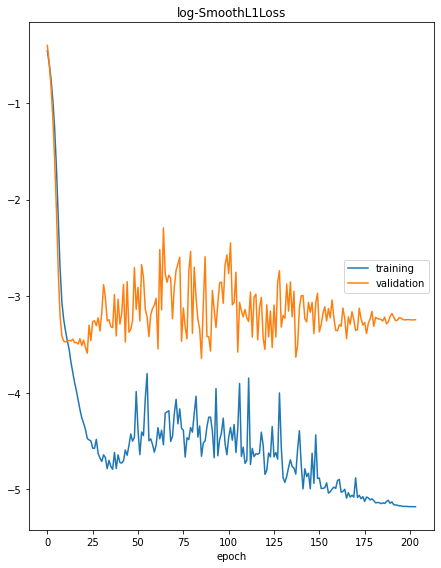

log-SmoothL1Loss
	training         	 (min:   -5.181, max:   -0.459, cur:   -5.181)
	validation       	 (min:   -3.645, max:   -0.402, cur:   -3.244)


In [40]:
data = seattle_gas_prices
df = data['data'].set_axis(['ds', 'y'], axis=1, inplace=False)

# https://rdrr.io/github/AlbertoAlmuinha/neuralprophet/man/neural_prophet.html
params = {
    # "seasonality_mode": "additive", 
    # "learning_rate": 0.1,
    # "n_changepoints": 40, # 48
    # "changepoints_range": 0.95, 
    # "trend_reg": 1,
    # "num_hidden_layers": 2,
    # "d_hidden": 64,
    # "yearly_seasonality": True, # True
    # "weekly_seasonality": False,
    # "daily_seasonality": False,
    # "loss_func": 'MSE',
    # "n_lags": 12,
    # "user_changepoints", 
}

model = NeuralProphet(**params)

df_train, df_test = model.split_df(df=df, freq="W", valid_p=0.15)

metrics =  model.fit(df_train, freq="W", validation_df=df_test, progress="plot")

In [41]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
203,0.005621,0.196717,0.258867,0.0,0.038996,0.587334,0.708228


### Evaluation

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.039  0.587  0.708


   SmoothL1Loss       MAE      RMSE
0      0.038996  0.587334  0.708228


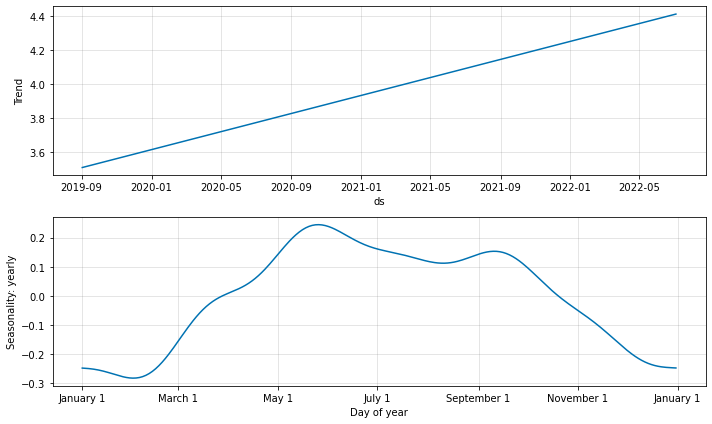

In [42]:
test_pred = model.predict(df_test)
test_components = model.plot_components(test_pred)

test_metrics = model.test(df_test)
print(test_metrics)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


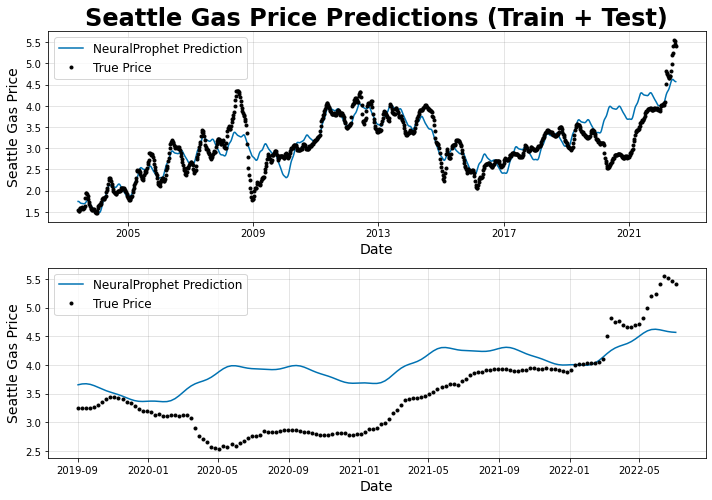

In [43]:
# fig, ax = plt.subplots(figsize=(10, 7))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
model.plot(model.predict(df), ax=ax1)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Seattle Gas Price', fontsize=14)
ax1.set_title("Seattle Gas Price Predictions (Train + Test)", fontsize=24, fontweight="bold")
ax1.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

# fig, ax = plt.subplots(figsize=(10, 7))
model.plot(test_pred, xlabel='Date', ylabel='Seattle Gas Price', ax=ax2)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Seattle Gas Price', fontsize=14)
ax2.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

### Forecasting

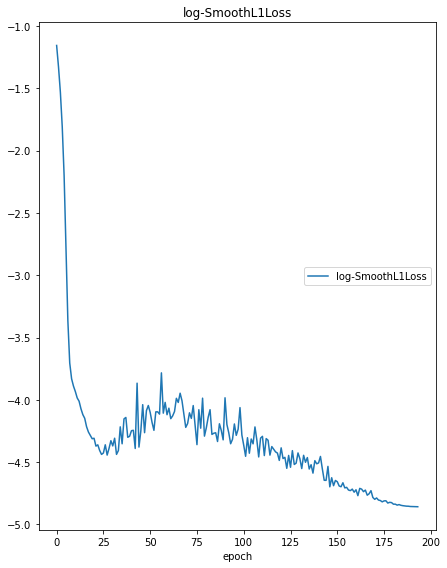

log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -4.858, max:   -1.155, cur:   -4.858)


In [44]:
model2 = NeuralProphet(**params)
metrics_train2 = model2.fit(df=df, freq="W", progress="plot")

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


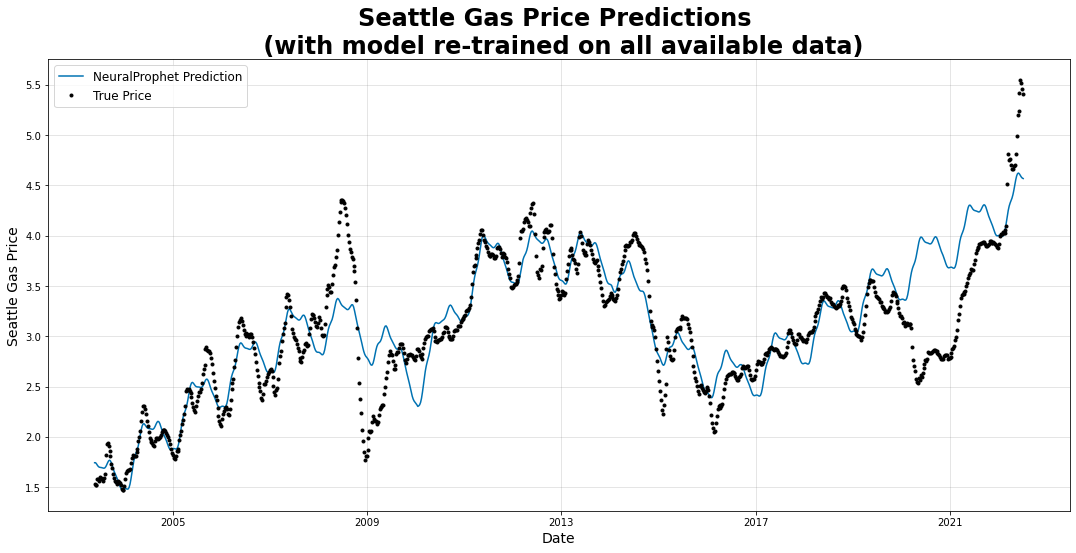

In [45]:
# fig = model.plot(model2.predict(df))
fig, ax = plt.subplots(figsize=(15, 7))
model.plot(model.predict(df), ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Predictions \n (with model re-trained on all available data)", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

In [46]:
future = model2.make_future_dataframe(df, periods=12, n_historic_predictions=96)
forecast = model2.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: T

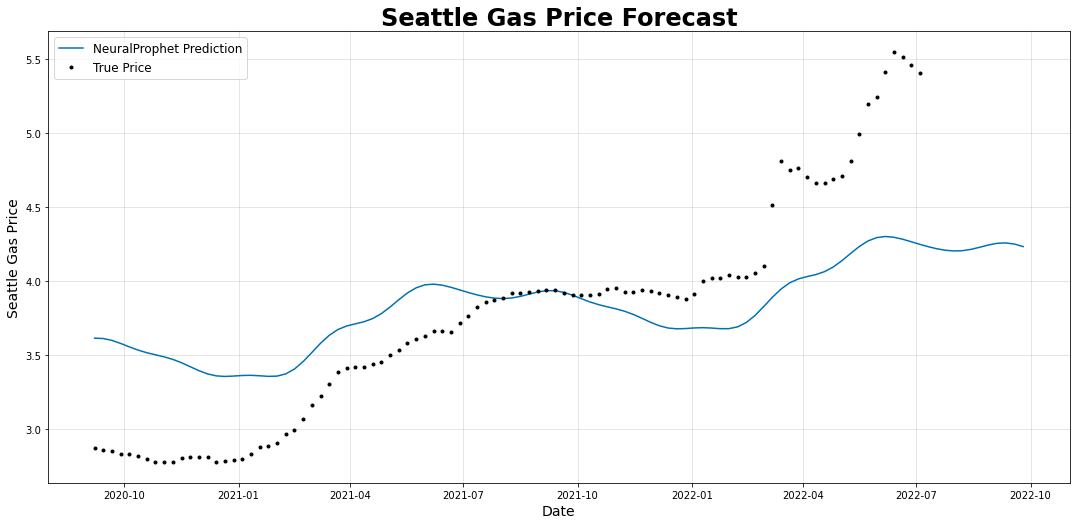

In [47]:
# fig = model2.plot(forecast)

fig, ax = plt.subplots(figsize=(15, 7))
model.plot(forecast, ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Forecast", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

## 6b. Neural Network (LSTM)

In [48]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, dropout=0.1):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Define activation function
        self.relu = nn.ReLU()

    def forward(self, x, y_hist, h_0, c_0):
        
        # Propagate input through LSTM
        self.lstm.flatten_parameters()
        
        # combine  x and y history tensors
        x = torch.cat((x, y_hist), dim=-1)
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        out = self.relu(output[:,-1,:])
        out = self.fc(out) 
        
        return out, hn, cn
    
    def init_hidden_internal(self, batch_size):
        h_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size)).to(device)
        return h_0, c_0

### Training

In [49]:
lstm = LSTM(num_classes=1, input_size=n_timeseries+1, hidden_size=64, num_layers=2, # hidden=64, layers=2
             seq_length=timesteps, dropout=0.2)
model_name = 'lstm'
lstm_opt = torch.optim.Adam(lstm.parameters(), lr=0.01)
lstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=lstm_opt, patience=15)

Validation loss decreased (inf --> 0.003216).  Saving model ...
Iter:  0 train:  0.17625941327332134 val:  0.056709529333852086 LR:  0.01
mse:  0.021423394 mae:  0.1189496


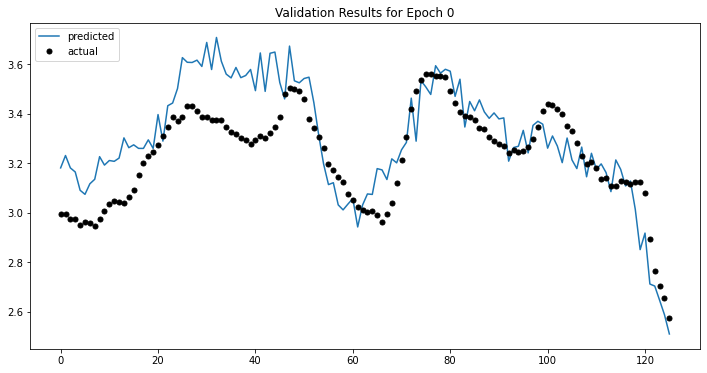

EarlyStopping counter: 1 out of 50
Iter:  1 train:  0.06685347531534429 val:  0.1274411394552273 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  2 train:  0.05403271899430157 val:  0.12906827395556664 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  3 train:  0.05143980770773493 val:  0.10685695770061505 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  4 train:  0.05304498013613262 val:  0.10030354102883939 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  5 train:  0.04639845438042369 val:  0.09155401812263927 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  6 train:  0.04641431740697886 val:  0.05863057000193378 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  7 train:  0.04196815346420269 val:  0.1053947193678105 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  8 train:  0.038306751382496035 val:  0.10441734302853718 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  9 train:  0.04051449870386607 val:  0.08834085069172473 LR:  0.01
EarlyStopping counter: 10 out

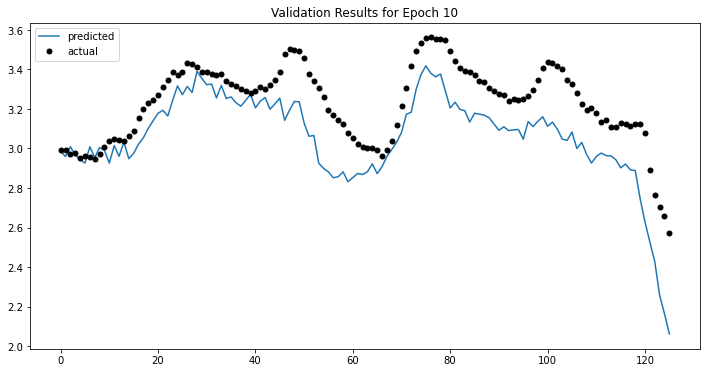

EarlyStopping counter: 11 out of 50
Iter:  11 train:  0.03787541770626239 val:  0.0653957616706547 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  12 train:  0.03294264574732478 val:  0.09035734065913208 LR:  0.01
Validation loss decreased (0.003216 --> 0.002623).  Saving model ...
Iter:  13 train:  0.031376295116424265 val:  0.05121321724689348 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  14 train:  0.04007823312797526 val:  0.07588401324753259 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  15 train:  0.03438344064005635 val:  0.07518887885500265 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  16 train:  0.033786498923497776 val:  0.09325733783202592 LR:  0.01
Validation loss decreased (0.002623 --> 0.002450).  Saving model ...
Iter:  17 train:  0.0328966926371873 val:  0.049497199779624856 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  18 train:  0.028650609300992804 val:  0.06803871400562615 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  19 train:  0.0

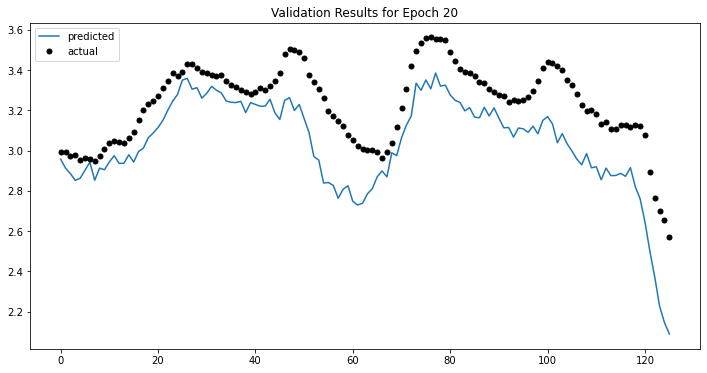

EarlyStopping counter: 4 out of 50
Iter:  21 train:  0.030386074519234467 val:  0.056848213192664816 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  22 train:  0.02719439120931328 val:  0.06639500146718248 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  23 train:  0.02698327853951214 val:  0.05103774503143657 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  24 train:  0.02683018317494435 val:  0.07330296568063385 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  25 train:  0.027337214107933182 val:  0.07814472002585406 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  26 train:  0.03048562608050685 val:  0.06630779662891463 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  27 train:  0.029424685047984307 val:  0.06867418434878776 LR:  0.01
Validation loss decreased (0.002450 --> 0.001979).  Saving model ...
Iter:  28 train:  0.028699090025581575 val:  0.044489085467832534 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  29 train:  0.030448116272044513 val:  0.07978

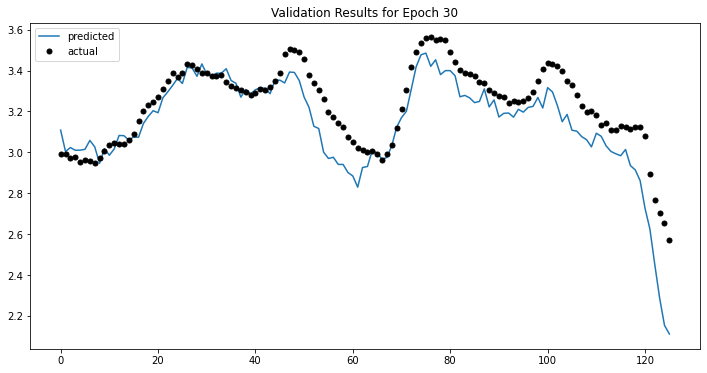

EarlyStopping counter: 3 out of 50
Iter:  31 train:  0.0280511634423543 val:  0.056381728605569 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  32 train:  0.023665095148682407 val:  0.04759394589260606 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  33 train:  0.02732508332421037 val:  0.04530172681588825 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  34 train:  0.029137337002157253 val:  0.05821840965476802 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  35 train:  0.025250451044620825 val:  0.05097761939687937 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  36 train:  0.027842632262470315 val:  0.07051647482618838 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  37 train:  0.02958911702994615 val:  0.04470458988802801 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  38 train:  0.028656131044735602 val:  0.06456338466134084 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  39 train:  0.024372571721253882 val:  0.06054350081918998 LR:  0.01
EarlyStopping 

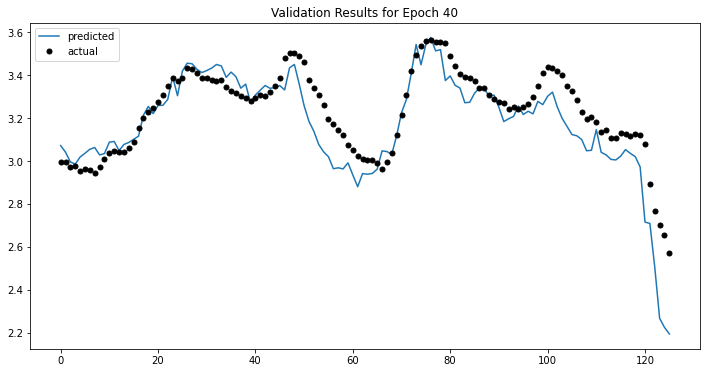

EarlyStopping counter: 13 out of 50
Iter:  41 train:  0.026054155784897975 val:  0.04618522036943736 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  42 train:  0.02338613107460027 val:  0.05663031160926608 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  43 train:  0.023685647682782345 val:  0.049199257787400544 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  44 train:  0.02425783777664362 val:  0.053516735283999334 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  45 train:  0.020168403310370918 val:  0.05149525059807316 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  46 train:  0.018104458844467375 val:  0.046229516202284056 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  47 train:  0.018387382056589123 val:  0.05147480721793553 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  48 train:  0.017365296312706356 val:  0.05027139681349514 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  49 train:  0.01754874688487917 val:  0.047974020593806864 LR:  

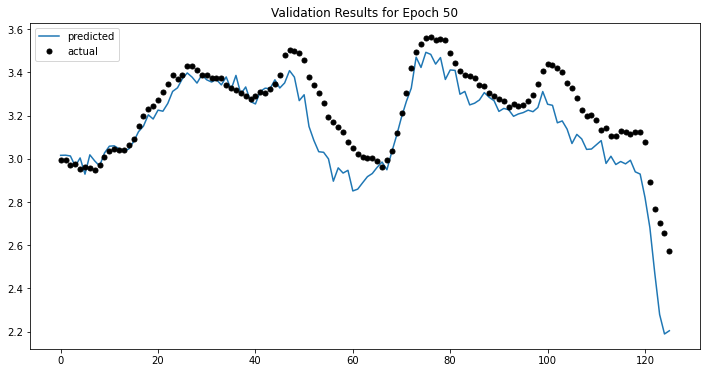

EarlyStopping counter: 23 out of 50
Iter:  51 train:  0.017288904016987197 val:  0.04736793966376548 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  52 train:  0.016850289248701477 val:  0.04682373146226976 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  53 train:  0.017872996785442827 val:  0.05065352272785919 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  54 train:  0.01757998099506285 val:  0.046885488435937636 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  55 train:  0.016481168620931703 val:  0.04495115281216488 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  56 train:  0.0170333149185656 val:  0.05034822138124779 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  57 train:  0.016772757904943567 val:  0.04665753510925357 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  58 train:  0.016368089021118304 val:  0.04627394986112173 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  59 train:  0.016037037576883698 val:  0.04559085808647035 LR:  

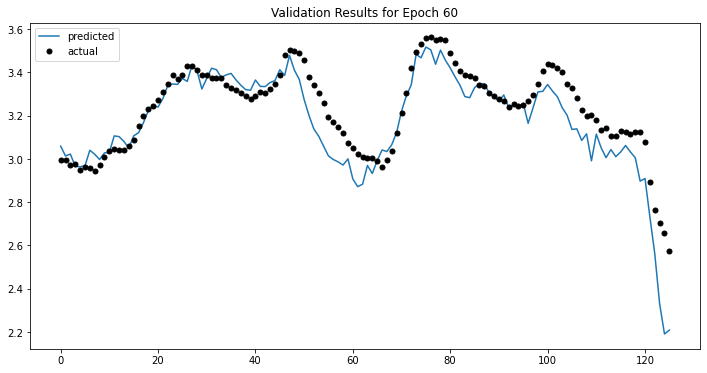

EarlyStopping counter: 1 out of 50
Iter:  61 train:  0.018473585776156563 val:  0.043881838108150356 LR:  0.001
EarlyStopping counter: 2 out of 50
Iter:  62 train:  0.016183917441329174 val:  0.04761479118486613 LR:  0.001
EarlyStopping counter: 3 out of 50
Iter:  63 train:  0.016349206607115755 val:  0.047199111382654854 LR:  0.001
EarlyStopping counter: 4 out of 50
Iter:  64 train:  0.015865659369455068 val:  0.04269623616580491 LR:  0.001
EarlyStopping counter: 5 out of 50
Iter:  65 train:  0.01583329356153705 val:  0.042822482603869436 LR:  0.001
EarlyStopping counter: 6 out of 50
Iter:  66 train:  0.016437758178016165 val:  0.0432829436794479 LR:  0.001
EarlyStopping counter: 7 out of 50
Iter:  67 train:  0.015859406762853388 val:  0.04484469276906226 LR:  0.001
EarlyStopping counter: 8 out of 50
Iter:  68 train:  0.016406193279708346 val:  0.04333580096441451 LR:  0.001
EarlyStopping counter: 9 out of 50
Iter:  69 train:  0.016181301273262148 val:  0.04550135394279262 LR:  0.001


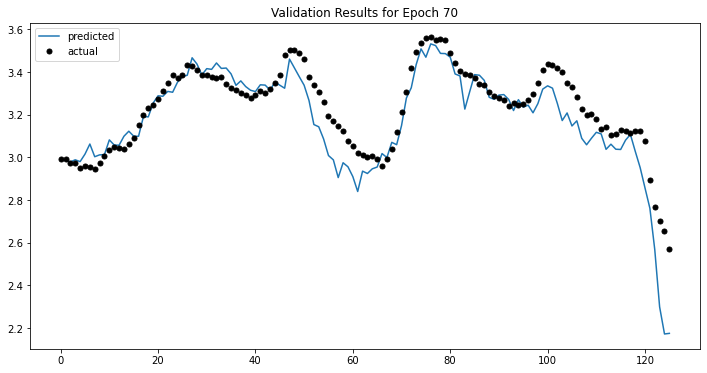

Validation loss decreased (0.001802 --> 0.001701).  Saving model ...
Iter:  71 train:  0.015728810179390068 val:  0.04124789700098957 LR:  0.001
EarlyStopping counter: 1 out of 50
Iter:  72 train:  0.01620465998781971 val:  0.04406927225731667 LR:  0.001
EarlyStopping counter: 2 out of 50
Iter:  73 train:  0.01605075972600605 val:  0.0432873781694943 LR:  0.001
EarlyStopping counter: 3 out of 50
Iter:  74 train:  0.015242954647380014 val:  0.042257869095783676 LR:  0.001
EarlyStopping counter: 4 out of 50
Iter:  75 train:  0.01596109815192545 val:  0.04348823774148493 LR:  0.001
Validation loss decreased (0.001701 --> 0.001669).  Saving model ...
Iter:  76 train:  0.01621805184097106 val:  0.040852275656701784 LR:  0.001
EarlyStopping counter: 1 out of 50
Iter:  77 train:  0.01588149571559085 val:  0.04155555767038409 LR:  0.001
EarlyStopping counter: 2 out of 50
Iter:  78 train:  0.015432559324666648 val:  0.04256617478859068 LR:  0.001
EarlyStopping counter: 3 out of 50
Iter:  79 tra

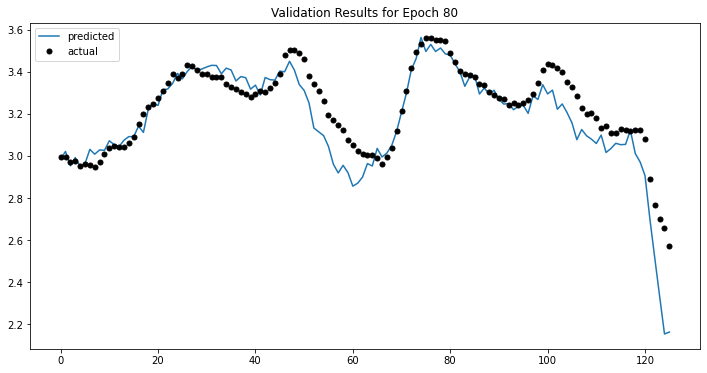

EarlyStopping counter: 5 out of 50
Iter:  81 train:  0.01542877109881836 val:  0.04668179875905985 LR:  0.001
Validation loss decreased (0.001669 --> 0.001590).  Saving model ...
Iter:  82 train:  0.015623961296054015 val:  0.03987603975252364 LR:  0.001
EarlyStopping counter: 1 out of 50
Iter:  83 train:  0.01514323527235442 val:  0.04259737456422303 LR:  0.001
EarlyStopping counter: 2 out of 50
Iter:  84 train:  0.014852597751614693 val:  0.04356136699393553 LR:  0.001
EarlyStopping counter: 3 out of 50
Iter:  85 train:  0.015366743141939745 val:  0.04468661468276005 LR:  0.001
EarlyStopping counter: 4 out of 50
Iter:  86 train:  0.015726727975958737 val:  0.0442362352623428 LR:  0.001
EarlyStopping counter: 5 out of 50
Iter:  87 train:  0.014817919782838146 val:  0.04636857788280229 LR:  0.001
EarlyStopping counter: 6 out of 50
Iter:  88 train:  0.015952136194254642 val:  0.04565438672963454 LR:  0.001
EarlyStopping counter: 7 out of 50
Iter:  89 train:  0.01578799658807252 val:  0.

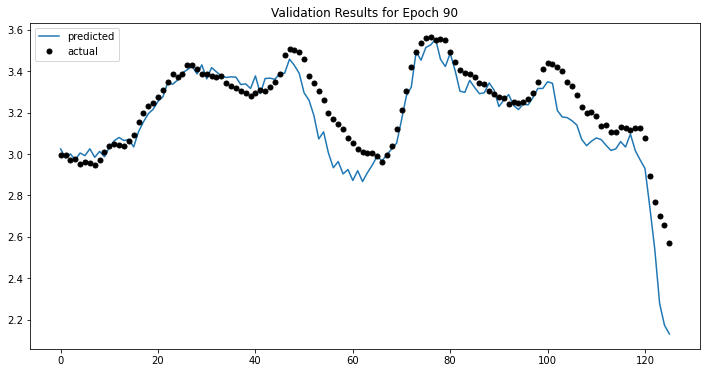

EarlyStopping counter: 9 out of 50
Iter:  91 train:  0.014678406532419438 val:  0.04447949329573014 LR:  0.001
EarlyStopping counter: 10 out of 50
Iter:  92 train:  0.015510536480502324 val:  0.040325751845380266 LR:  0.001
EarlyStopping counter: 11 out of 50
Iter:  93 train:  0.015171269534095621 val:  0.041113825529863986 LR:  0.001
EarlyStopping counter: 12 out of 50
Iter:  94 train:  0.015162365723689453 val:  0.041300909723072474 LR:  0.001
EarlyStopping counter: 13 out of 50
Iter:  95 train:  0.015199493722755907 val:  0.042549670697510415 LR:  0.001
EarlyStopping counter: 14 out of 50
Iter:  96 train:  0.01501079618231565 val:  0.04381602671438189 LR:  0.001
EarlyStopping counter: 15 out of 50
Iter:  97 train:  0.014732021908989843 val:  0.041555208556371716 LR:  0.001
EarlyStopping counter: 16 out of 50
Iter:  98 train:  0.014905290527320352 val:  0.04277634400272231 LR:  0.0001
EarlyStopping counter: 17 out of 50
Iter:  99 train:  0.014445815483368362 val:  0.04114856073836972

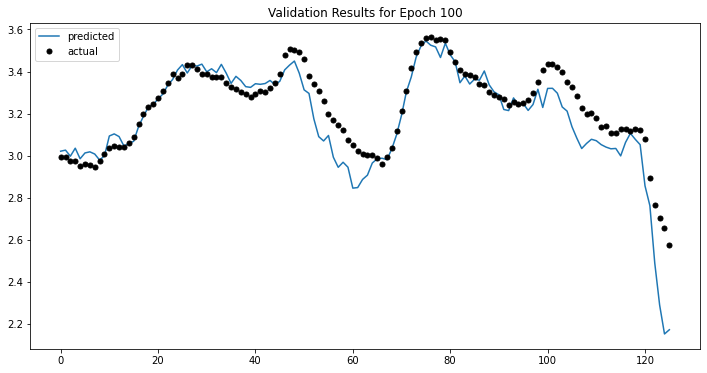

EarlyStopping counter: 19 out of 50
Iter:  101 train:  0.013380358535807064 val:  0.041187814144274706 LR:  0.0001
EarlyStopping counter: 20 out of 50
Iter:  102 train:  0.01384471180638753 val:  0.04011731207862699 LR:  0.0001
EarlyStopping counter: 21 out of 50
Iter:  103 train:  0.014624655355139038 val:  0.04248959654531288 LR:  0.0001
EarlyStopping counter: 22 out of 50
Iter:  104 train:  0.013925377846150205 val:  0.04045503332714152 LR:  0.0001
EarlyStopping counter: 23 out of 50
Iter:  105 train:  0.014194797655982793 val:  0.0413606761004797 LR:  0.0001
EarlyStopping counter: 24 out of 50
Iter:  106 train:  0.01400839642316389 val:  0.04333702138364144 LR:  0.0001
EarlyStopping counter: 25 out of 50
Iter:  107 train:  0.014001641776259793 val:  0.04453173828816678 LR:  0.0001
EarlyStopping counter: 26 out of 50
Iter:  108 train:  0.01318780081931791 val:  0.04170604830028504 LR:  0.0001
EarlyStopping counter: 27 out of 50
Iter:  109 train:  0.013491806678033694 val:  0.0420851

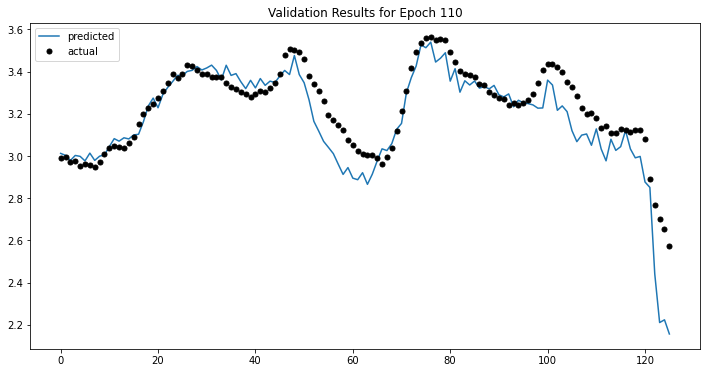

EarlyStopping counter: 29 out of 50
Iter:  111 train:  0.014119065663452873 val:  0.04414147217824796 LR:  0.0001
EarlyStopping counter: 30 out of 50
Iter:  112 train:  0.014226018099775152 val:  0.04023638928758422 LR:  0.0001
EarlyStopping counter: 31 out of 50
Iter:  113 train:  0.013960828479133202 val:  0.04093179022329198 LR:  0.0001
EarlyStopping counter: 32 out of 50
Iter:  114 train:  0.014417999549810295 val:  0.042841039082835874 LR:  1e-05
EarlyStopping counter: 33 out of 50
Iter:  115 train:  0.01406979428371838 val:  0.042784539778914346 LR:  1e-05
EarlyStopping counter: 34 out of 50
Iter:  116 train:  0.013113098305749478 val:  0.043085096642863564 LR:  1e-05
EarlyStopping counter: 35 out of 50
Iter:  117 train:  0.013894067392417896 val:  0.041038131067069064 LR:  1e-05
EarlyStopping counter: 36 out of 50
Iter:  118 train:  0.014759424263048247 val:  0.04201384517801141 LR:  1e-05
EarlyStopping counter: 37 out of 50
Iter:  119 train:  0.013765907284905303 val:  0.041495

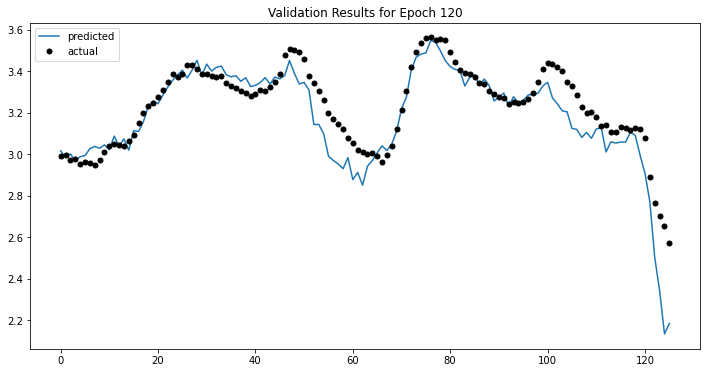

EarlyStopping counter: 39 out of 50
Iter:  121 train:  0.013314696196577849 val:  0.04122075780960004 LR:  1e-05
EarlyStopping counter: 40 out of 50
Iter:  122 train:  0.01379465179730518 val:  0.04141261224991278 LR:  1e-05
EarlyStopping counter: 41 out of 50
Iter:  123 train:  0.01359785624239816 val:  0.04011146707447724 LR:  1e-05
EarlyStopping counter: 42 out of 50
Iter:  124 train:  0.013815571023176366 val:  0.04345257414178837 LR:  1e-05
EarlyStopping counter: 43 out of 50
Iter:  125 train:  0.014261179142684327 val:  0.041660307399110294 LR:  1e-05
EarlyStopping counter: 44 out of 50
Iter:  126 train:  0.01397124351727244 val:  0.04403734911319715 LR:  1e-05
EarlyStopping counter: 45 out of 50
Iter:  127 train:  0.014088839342213421 val:  0.042218757052391455 LR:  1e-05
EarlyStopping counter: 46 out of 50
Iter:  128 train:  0.014012410922344308 val:  0.04114758655726567 LR:  1e-05
EarlyStopping counter: 47 out of 50
Iter:  129 train:  0.013437240730339453 val:  0.0436635540913

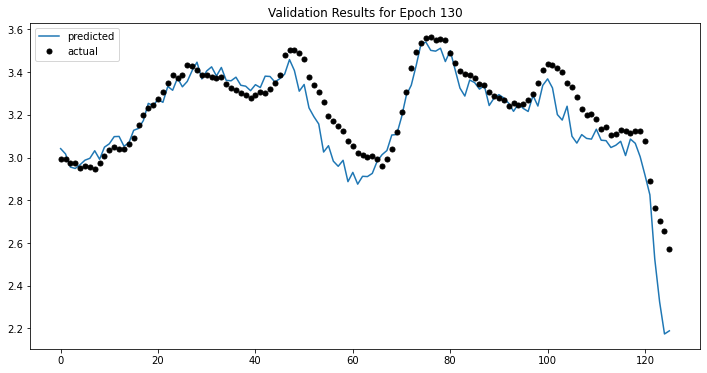

EarlyStopping counter: 49 out of 50
Iter:  131 train:  0.014036580421576262 val:  0.041434270657166046 LR:  1.0000000000000002e-06
EarlyStopping counter: 50 out of 50
Early stopping


In [50]:
nn_train(model=lstm, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=lstm_opt, 
         scheduler=lstm_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [51]:
lstm.load_state_dict(torch.load("lstm.pt"))

<All keys matched successfully>

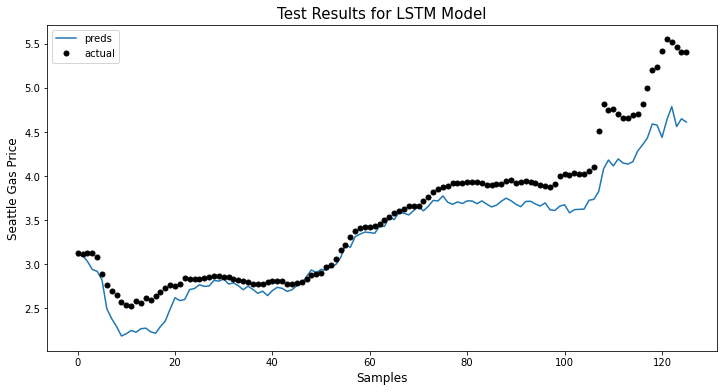

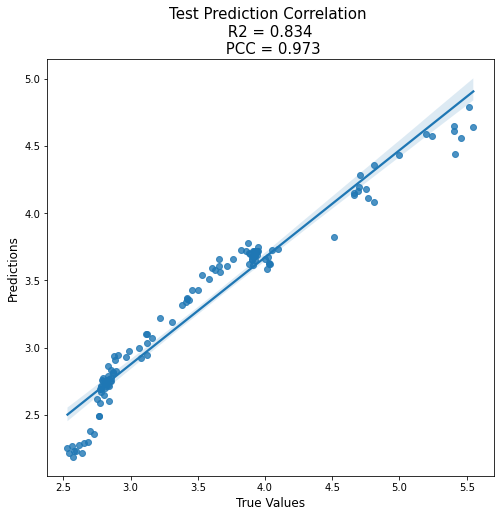

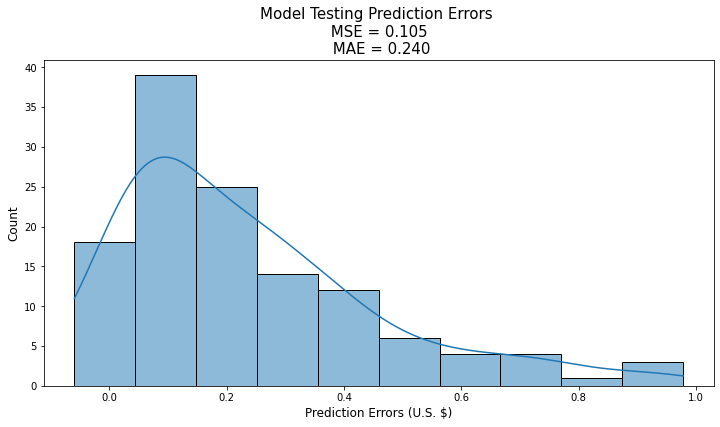

In [52]:
lstm_mse, lstm_mae, lstm_r2, lstm_pcc, lstm_preds, lstm_true = nn_eval(model=lstm, 
                                                                       model_name='lstm', 
                                                                       data_test_loader=data_test_loader, 
                                                                       target_scaler=target_scaler)

### Forecasting

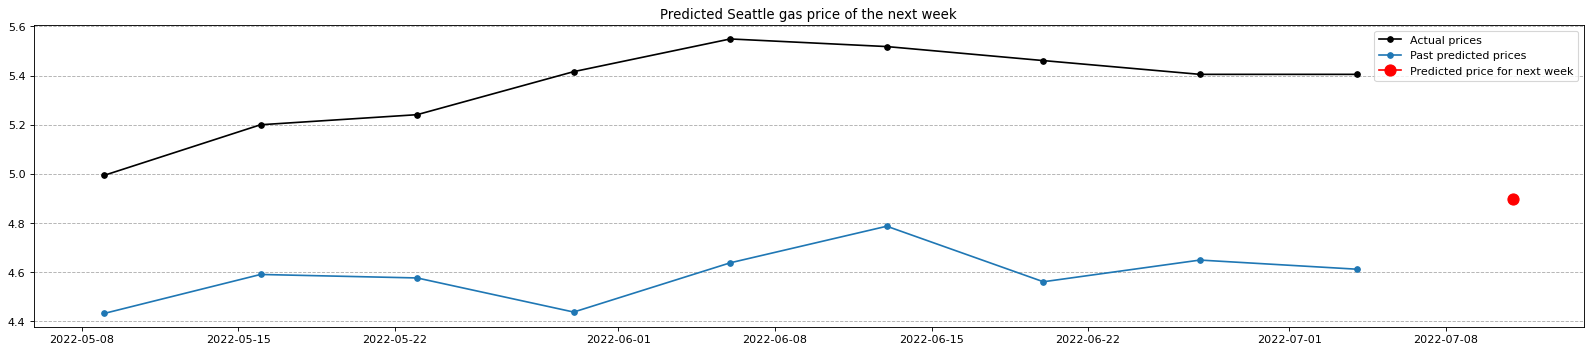

LSTM Predicted Seattle Gas Price of the next week: $4.90


In [60]:
nn_forecast(model = lstm,
            model_name = 'lstm', 
            x = X_, 
            y_hist = y_, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = lstm_true, 
            preds = lstm_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

## 6c. Attentioned-Based Neural Network (DA-RNN)

In [54]:
class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, device, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T
        
        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)
        
        #equation 8 matrices
        
        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        self.v_e = nn.Linear(self.T, 1, bias=False)
    
    def forward(self, inputs):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M)).to(device)
        
        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M)).to(device)
        s_tm1 = torch.zeros((inputs.size(0), self.M)).to(device)
        
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)
            
            #attention weights for each k in N (equation 8)
            x = self.W_e(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))
        
            #normalize attention weights (equation 9)
            alpha_k_t = F.softmax(e_k_t, dim=1)
            
            #weight inputs (equation 10)
            weighted_inputs = alpha_k_t * inputs[:, t, :] 
    
            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            
            encoded_inputs[:, t, :] = h_tm1
        return encoded_inputs
    
class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, device, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful
        
        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)
        
        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)
        
        #equation 15 matrix
        self.w_tilda = nn.Linear(self.M + 1, 1)
        
        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, 1)
        
    def forward(self, encoded_inputs, y):
        
        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).to(device)
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).to(device)
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)
            
            #normalized attention weights (equation 13)
            beta_i_t = F.softmax(l_i_t, dim=1)
            
            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)
            
            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)
            
            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))
        
        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1
    
class DARNN(nn.Module):
    def __init__(self, N, M, P, T, device, stateful_encoder=False, stateful_decoder=False):
        """
        :param: N: int
            number of time series
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful_encoder & stateful_decoder:
            decides whether to initialize cell state of new time window with 
            values of the last cell state of previous time window or to 
            initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, device, stateful_encoder).to(device)
        self.decoder = TemporalAttentionDecoder(M, P, T, device, stateful_decoder).to(device)
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

### Training

In [55]:
darnn = DARNN(N=X_train.shape[2], M=64, P=16, T=X_train.shape[1], device=device).to(device) # 1) M=64, N=16; 2) M=32, N=32
opt = torch.optim.Adam(darnn.parameters(), lr=0.01)
epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, patience=15)

In [56]:
epochs = 1000
loss = nn.MSELoss()

# initialize the early_stopping object
patience = config["model"]["patience"]
early_stopping = EarlyStopping(patience=50, verbose=True, path='darnn.pt') 

for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader :
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_h = batch_y_h.to(device)
        opt.zero_grad()
        y_pred = darnn(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            output = darnn(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    # Learning rate scheduler
    epoch_scheduler.step(mse_val/len(X_val_t))
    lr = opt.param_groups[0]['lr']
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(mse_val/len(X_val_t), darnn)

    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, 
          "val: ", (mse_val/len(X_val_t))**0.5, 
          "LR: ", lr
         )
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

NameError: name 'config' is not defined

### Evaluation

In [ ]:
darnn.load_state_dict(torch.load("darnn.pt"))

In [ ]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_h = batch_y_h.to(device)
        output = darnn(batch_x, batch_y_h)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(torch.squeeze(output), batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [ ]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

### Forecasting

# 8. Model Comparison